# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [107]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 22 (delta 3), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (22/22), done.


In [108]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7/deep-learning-polytech-tp6-7/deep-learning-polytech-tp6-7/deep-learning-polytech-tp6-7/deep-learning-polytech-tp6-7/deep-learning-polytech-tp6-7


In [109]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim.lr_scheduler

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [112]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            #nn.Dropout(0.25),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            #transforms.RandomCrop(28),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201))
            #transforms.RandomAffine(0, translate=(0.1, 0.1))
            transforms.RandomAffine(0, shear=(-10, 10, -10, 10))
            #svd_whiten
        ]))
    
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            #transforms.CenterCrop(28),
            transforms.ToTensor(),
            #transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    #lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        # updata lr
        #lr_sched.step()


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.440s (0.440s)	Loss 2.3020 (2.3020)	Prec@1   8.6 (  8.6)	Prec@5  54.7 ( 54.7)


<Figure size 432x288 with 0 Axes>

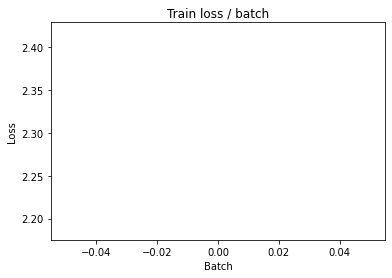

[TRAIN Batch 200/391]	Time 0.172s (0.181s)	Loss 1.5268 (1.7441)	Prec@1  46.1 ( 35.3)	Prec@5  90.6 ( 85.1)


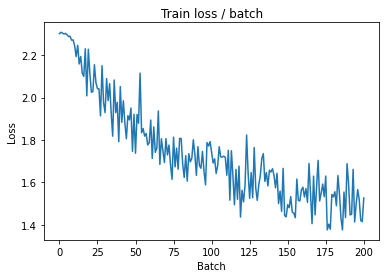


===============> Total time 70s	Avg loss 1.5705	Avg Prec@1 42.35 %	Avg Prec@5 88.93 %

[EVAL Batch 000/079]	Time 0.216s (0.216s)	Loss 1.1539 (1.1539)	Prec@1  60.9 ( 60.9)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 1.2430	Avg Prec@1 54.99 %	Avg Prec@5 94.49 %



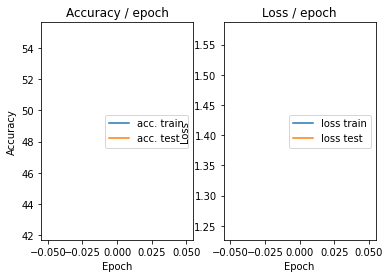

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.442s (0.442s)	Loss 1.2304 (1.2304)	Prec@1  54.7 ( 54.7)	Prec@5  95.3 ( 95.3)


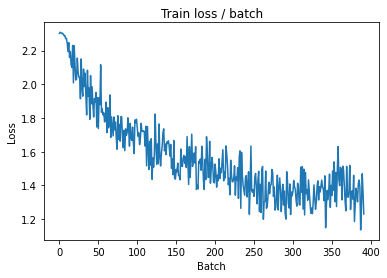

[TRAIN Batch 200/391]	Time 0.174s (0.182s)	Loss 0.9783 (1.2160)	Prec@1  64.8 ( 55.9)	Prec@5  97.7 ( 94.9)


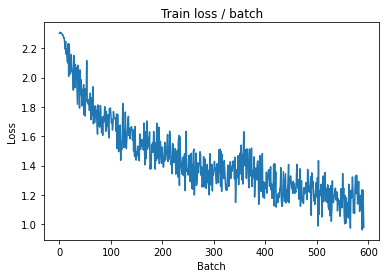


===============> Total time 71s	Avg loss 1.1765	Avg Prec@1 57.76 %	Avg Prec@5 95.25 %

[EVAL Batch 000/079]	Time 0.198s (0.198s)	Loss 0.9571 (0.9571)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 5s	Avg loss 1.1151	Avg Prec@1 60.26 %	Avg Prec@5 95.99 %



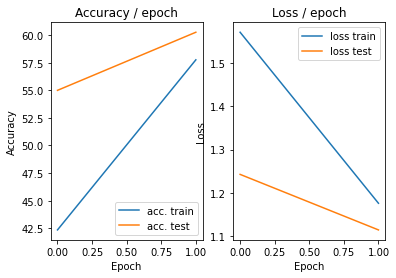

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.442s (0.442s)	Loss 1.0977 (1.0977)	Prec@1  57.8 ( 57.8)	Prec@5  96.1 ( 96.1)


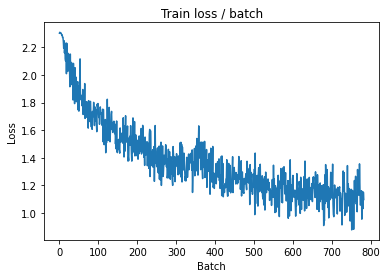

[TRAIN Batch 200/391]	Time 0.175s (0.186s)	Loss 0.7607 (1.0285)	Prec@1  76.6 ( 63.6)	Prec@5  98.4 ( 96.6)


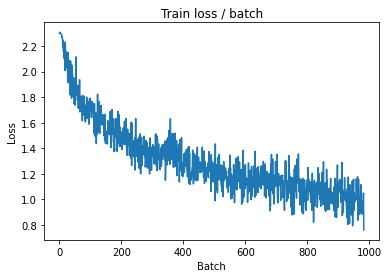


===============> Total time 72s	Avg loss 1.0088	Avg Prec@1 64.49 %	Avg Prec@5 96.69 %

[EVAL Batch 000/079]	Time 0.220s (0.220s)	Loss 0.8222 (0.8222)	Prec@1  69.5 ( 69.5)	Prec@5  98.4 ( 98.4)

===============> Total time 5s	Avg loss 0.9392	Avg Prec@1 66.27 %	Avg Prec@5 97.30 %



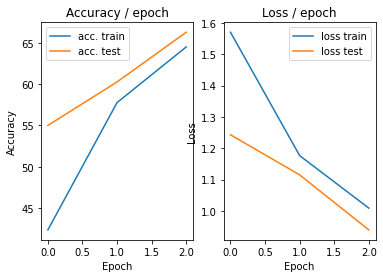

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.447s (0.447s)	Loss 1.0629 (1.0629)	Prec@1  64.1 ( 64.1)	Prec@5  94.5 ( 94.5)


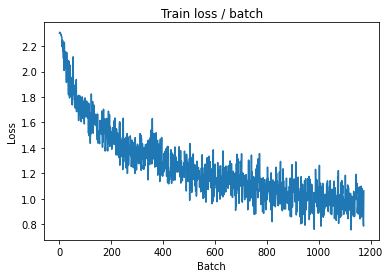

[TRAIN Batch 200/391]	Time 0.177s (0.184s)	Loss 0.8928 (0.8958)	Prec@1  69.5 ( 68.3)	Prec@5  98.4 ( 97.5)


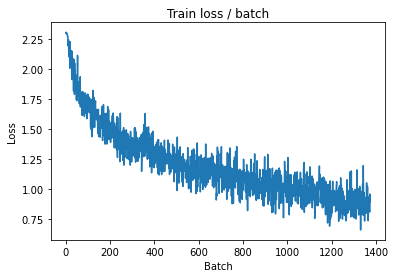


===============> Total time 71s	Avg loss 0.8874	Avg Prec@1 68.59 %	Avg Prec@5 97.53 %

[EVAL Batch 000/079]	Time 0.197s (0.197s)	Loss 0.8060 (0.8060)	Prec@1  75.0 ( 75.0)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 0.8952	Avg Prec@1 68.49 %	Avg Prec@5 97.36 %



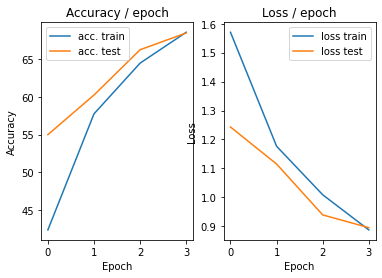

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.499s (0.499s)	Loss 0.8192 (0.8192)	Prec@1  66.4 ( 66.4)	Prec@5  99.2 ( 99.2)


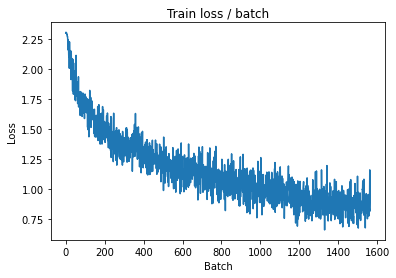

[TRAIN Batch 200/391]	Time 0.193s (0.184s)	Loss 0.8802 (0.7991)	Prec@1  68.8 ( 71.5)	Prec@5  97.7 ( 97.9)


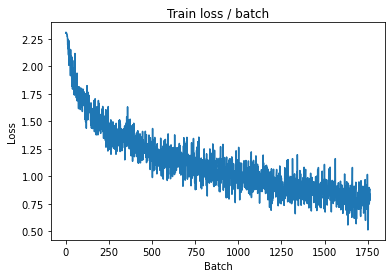


===============> Total time 71s	Avg loss 0.7997	Avg Prec@1 71.67 %	Avg Prec@5 97.99 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 0.7856 (0.7856)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 5s	Avg loss 0.8601	Avg Prec@1 70.06 %	Avg Prec@5 97.54 %



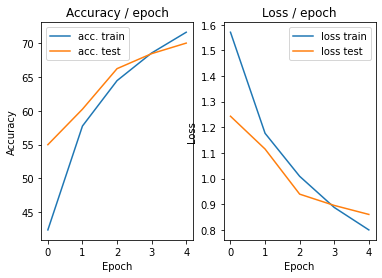

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.462s (0.462s)	Loss 0.7032 (0.7032)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)


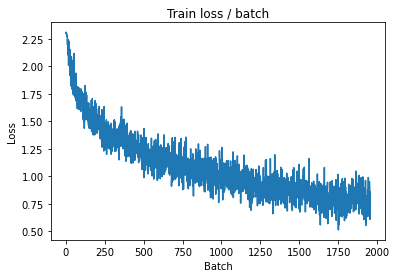

[TRAIN Batch 200/391]	Time 0.186s (0.187s)	Loss 0.7217 (0.7339)	Prec@1  70.3 ( 73.8)	Prec@5 100.0 ( 98.5)


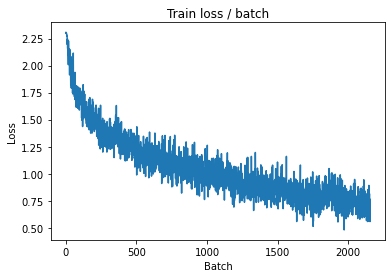


===============> Total time 72s	Avg loss 0.7350	Avg Prec@1 73.98 %	Avg Prec@5 98.39 %

[EVAL Batch 000/079]	Time 0.209s (0.209s)	Loss 0.8518 (0.8518)	Prec@1  71.9 ( 71.9)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 0.8300	Avg Prec@1 71.15 %	Avg Prec@5 97.52 %



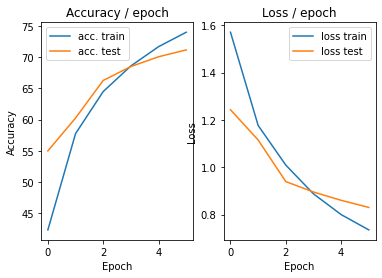

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.438s (0.438s)	Loss 0.7049 (0.7049)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)


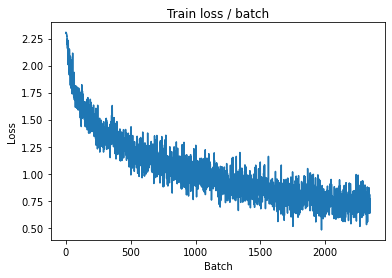

[TRAIN Batch 200/391]	Time 0.189s (0.185s)	Loss 0.8544 (0.6573)	Prec@1  71.1 ( 76.7)	Prec@5  96.9 ( 98.7)


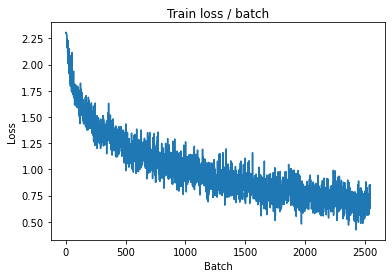


===============> Total time 71s	Avg loss 0.6543	Avg Prec@1 76.83 %	Avg Prec@5 98.76 %

[EVAL Batch 000/079]	Time 0.211s (0.211s)	Loss 0.7103 (0.7103)	Prec@1  75.8 ( 75.8)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 0.7688	Avg Prec@1 73.11 %	Avg Prec@5 97.85 %



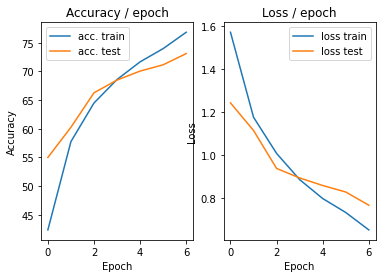

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.450s (0.450s)	Loss 0.6010 (0.6010)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)


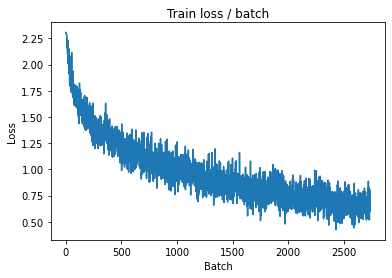

[TRAIN Batch 200/391]	Time 0.185s (0.185s)	Loss 0.5754 (0.5812)	Prec@1  78.9 ( 79.7)	Prec@5  98.4 ( 99.2)


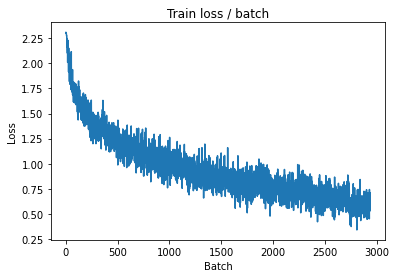


===============> Total time 72s	Avg loss 0.5972	Avg Prec@1 79.11 %	Avg Prec@5 99.04 %

[EVAL Batch 000/079]	Time 0.200s (0.200s)	Loss 0.8612 (0.8612)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)

===============> Total time 5s	Avg loss 0.8208	Avg Prec@1 71.91 %	Avg Prec@5 97.54 %



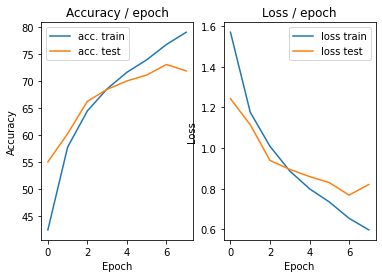

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.445s (0.445s)	Loss 0.5425 (0.5425)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)


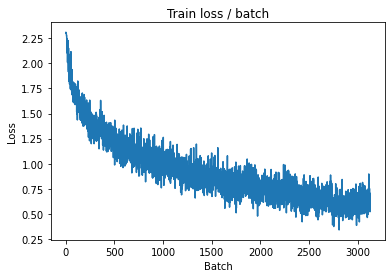

[TRAIN Batch 200/391]	Time 0.199s (0.187s)	Loss 0.5816 (0.5323)	Prec@1  79.7 ( 81.1)	Prec@5  97.7 ( 99.3)


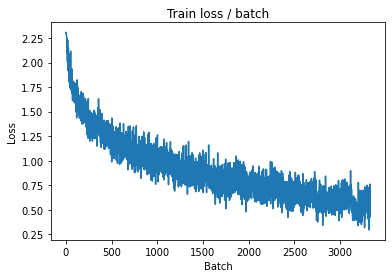


===============> Total time 72s	Avg loss 0.5449	Avg Prec@1 80.85 %	Avg Prec@5 99.22 %

[EVAL Batch 000/079]	Time 0.211s (0.211s)	Loss 0.9277 (0.9277)	Prec@1  74.2 ( 74.2)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 0.8051	Avg Prec@1 73.49 %	Avg Prec@5 97.96 %



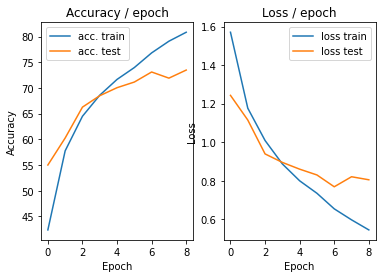

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.477s (0.477s)	Loss 0.5956 (0.5956)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)


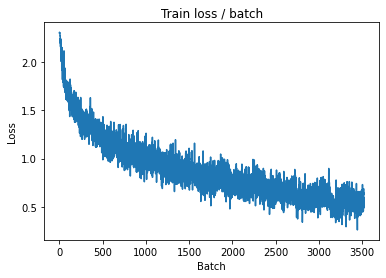

[TRAIN Batch 200/391]	Time 0.196s (0.186s)	Loss 0.4238 (0.4774)	Prec@1  85.9 ( 83.2)	Prec@5 100.0 ( 99.5)


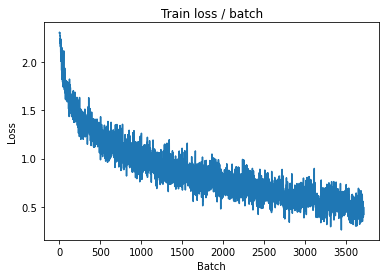


===============> Total time 72s	Avg loss 0.4899	Avg Prec@1 82.53 %	Avg Prec@5 99.43 %

[EVAL Batch 000/079]	Time 0.210s (0.210s)	Loss 0.8672 (0.8672)	Prec@1  74.2 ( 74.2)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 0.8143	Avg Prec@1 73.98 %	Avg Prec@5 98.02 %



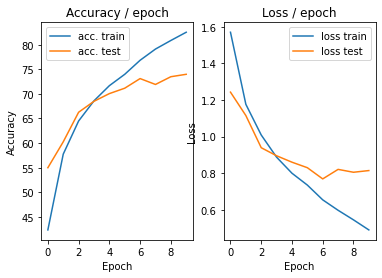

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.494s (0.494s)	Loss 0.3582 (0.3582)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


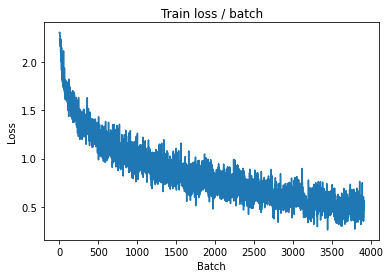

[TRAIN Batch 200/391]	Time 0.185s (0.186s)	Loss 0.5245 (0.4291)	Prec@1  82.0 ( 84.8)	Prec@5 100.0 ( 99.6)


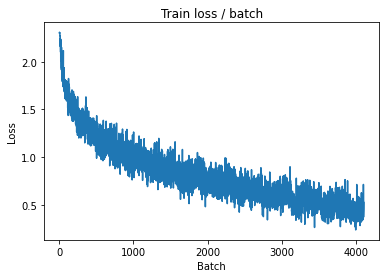


===============> Total time 72s	Avg loss 0.4355	Avg Prec@1 84.49 %	Avg Prec@5 99.59 %

[EVAL Batch 000/079]	Time 0.203s (0.203s)	Loss 0.8699 (0.8699)	Prec@1  77.3 ( 77.3)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 0.8122	Avg Prec@1 74.12 %	Avg Prec@5 97.87 %



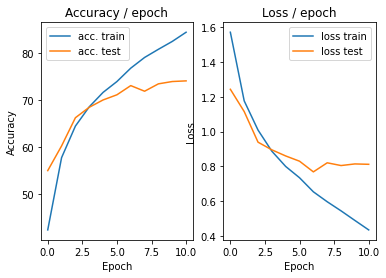

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.475s (0.475s)	Loss 0.3024 (0.3024)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


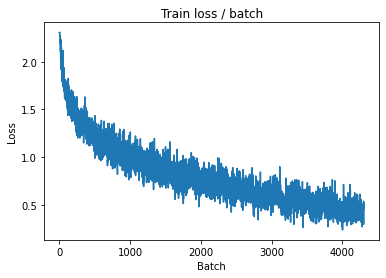

[TRAIN Batch 200/391]	Time 0.185s (0.185s)	Loss 0.3512 (0.3731)	Prec@1  85.2 ( 86.7)	Prec@5 100.0 ( 99.7)


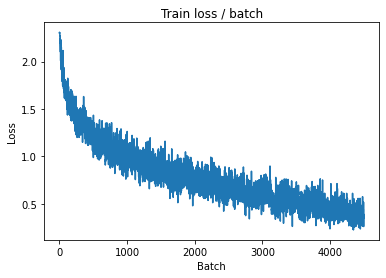


===============> Total time 72s	Avg loss 0.3891	Avg Prec@1 86.03 %	Avg Prec@5 99.70 %

[EVAL Batch 000/079]	Time 0.208s (0.208s)	Loss 0.9926 (0.9926)	Prec@1  78.1 ( 78.1)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 0.8052	Avg Prec@1 74.93 %	Avg Prec@5 98.26 %



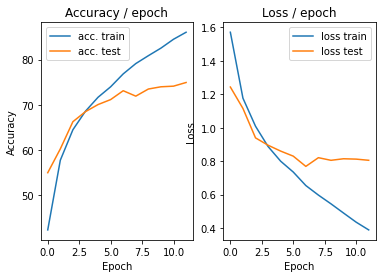

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.472s (0.472s)	Loss 0.3498 (0.3498)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


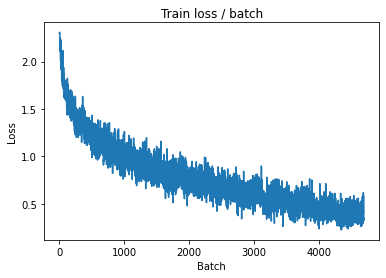

[TRAIN Batch 200/391]	Time 0.182s (0.186s)	Loss 0.2329 (0.3266)	Prec@1  93.0 ( 88.2)	Prec@5 100.0 ( 99.8)


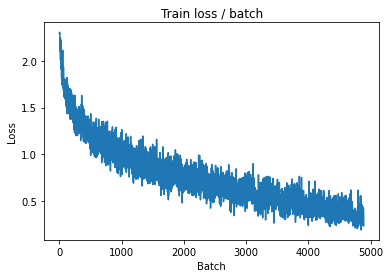


===============> Total time 72s	Avg loss 0.3443	Avg Prec@1 87.78 %	Avg Prec@5 99.79 %

[EVAL Batch 000/079]	Time 0.214s (0.214s)	Loss 1.1814 (1.1814)	Prec@1  76.6 ( 76.6)	Prec@5  95.3 ( 95.3)

===============> Total time 5s	Avg loss 0.8781	Avg Prec@1 74.49 %	Avg Prec@5 98.02 %



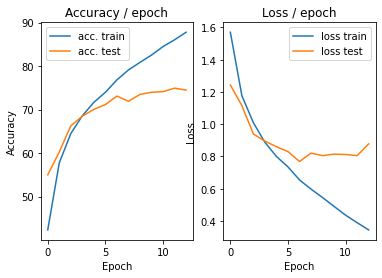

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.445s (0.445s)	Loss 0.2200 (0.2200)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


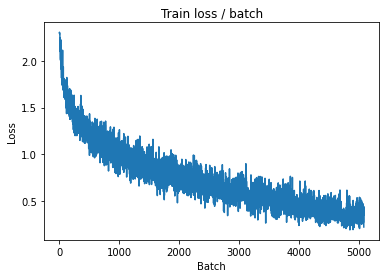

[TRAIN Batch 200/391]	Time 0.185s (0.186s)	Loss 0.3366 (0.2966)	Prec@1  88.3 ( 89.4)	Prec@5  99.2 ( 99.9)


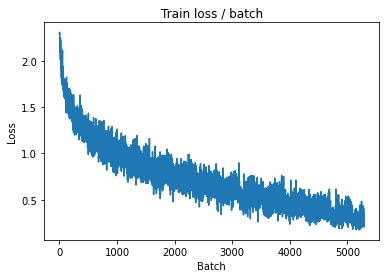


===============> Total time 72s	Avg loss 0.3054	Avg Prec@1 89.10 %	Avg Prec@5 99.88 %

[EVAL Batch 000/079]	Time 0.216s (0.216s)	Loss 1.1155 (1.1155)	Prec@1  75.8 ( 75.8)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 0.9336	Avg Prec@1 74.38 %	Avg Prec@5 98.01 %



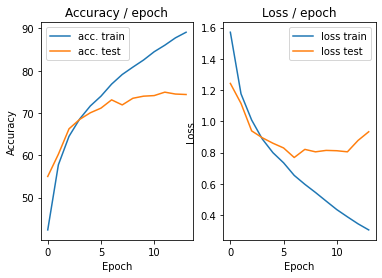

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.480s (0.480s)	Loss 0.1323 (0.1323)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


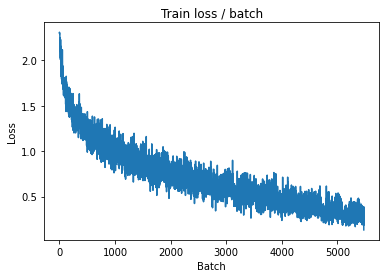

[TRAIN Batch 200/391]	Time 0.181s (0.186s)	Loss 0.2718 (0.2573)	Prec@1  90.6 ( 90.8)	Prec@5 100.0 ( 99.9)


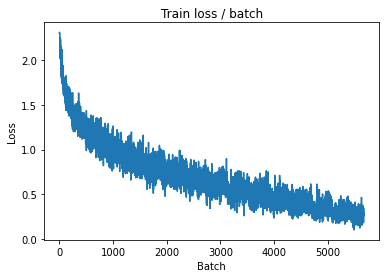


===============> Total time 72s	Avg loss 0.2757	Avg Prec@1 90.19 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.207s (0.207s)	Loss 1.0140 (1.0140)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 5s	Avg loss 0.9077	Avg Prec@1 75.11 %	Avg Prec@5 98.03 %



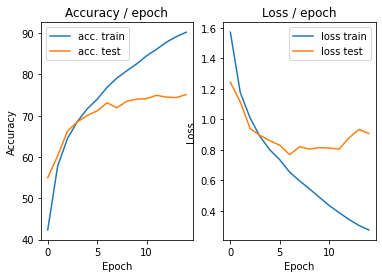

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.468s (0.468s)	Loss 0.1873 (0.1873)	Prec@1  93.8 ( 93.8)	Prec@5  99.2 ( 99.2)


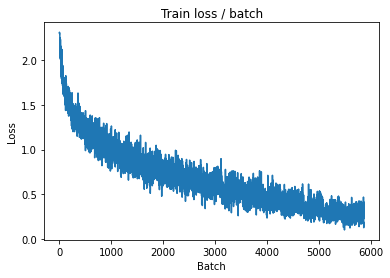

[TRAIN Batch 200/391]	Time 0.178s (0.185s)	Loss 0.3843 (0.2442)	Prec@1  84.4 ( 91.4)	Prec@5 100.0 ( 99.9)


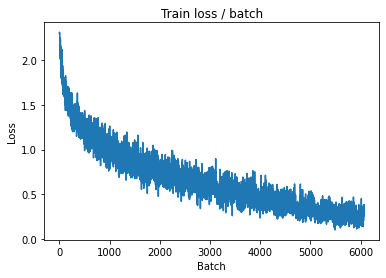


===============> Total time 72s	Avg loss 0.2562	Avg Prec@1 90.91 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.203s (0.203s)	Loss 1.1746 (1.1746)	Prec@1  78.9 ( 78.9)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 0.9648	Avg Prec@1 75.05 %	Avg Prec@5 97.76 %



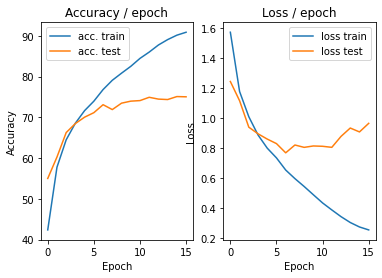

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.456s (0.456s)	Loss 0.2145 (0.2145)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


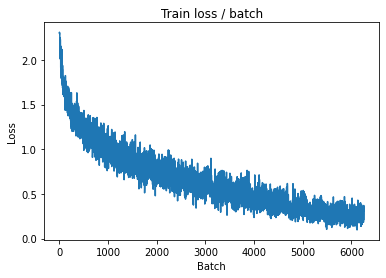

[TRAIN Batch 200/391]	Time 0.189s (0.187s)	Loss 0.1697 (0.2051)	Prec@1  93.8 ( 92.6)	Prec@5  99.2 ( 99.9)


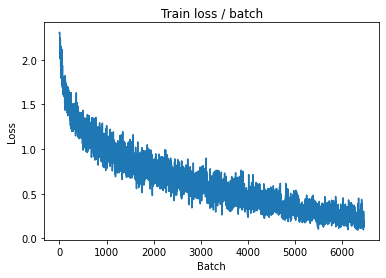


===============> Total time 72s	Avg loss 0.2249	Avg Prec@1 91.99 %	Avg Prec@5 99.94 %

[EVAL Batch 000/079]	Time 0.201s (0.201s)	Loss 1.2553 (1.2553)	Prec@1  78.1 ( 78.1)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 1.0321	Avg Prec@1 75.40 %	Avg Prec@5 97.95 %



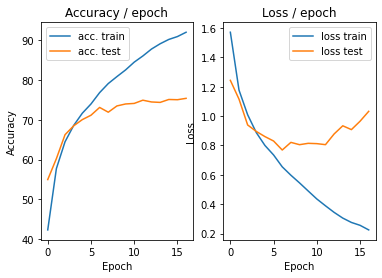

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.455s (0.455s)	Loss 0.1838 (0.1838)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


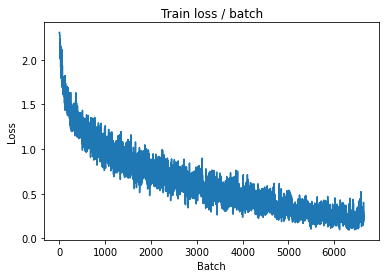

[TRAIN Batch 200/391]	Time 0.180s (0.186s)	Loss 0.1644 (0.1937)	Prec@1  93.0 ( 93.2)	Prec@5 100.0 (100.0)


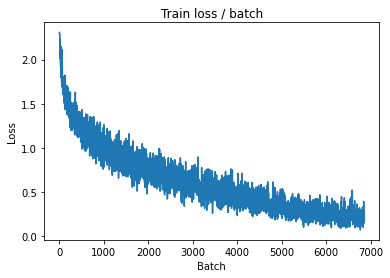


===============> Total time 72s	Avg loss 0.1990	Avg Prec@1 92.97 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.225s (0.225s)	Loss 1.1730 (1.1730)	Prec@1  78.1 ( 78.1)	Prec@5  96.9 ( 96.9)

===============> Total time 5s	Avg loss 1.1187	Avg Prec@1 74.17 %	Avg Prec@5 97.75 %



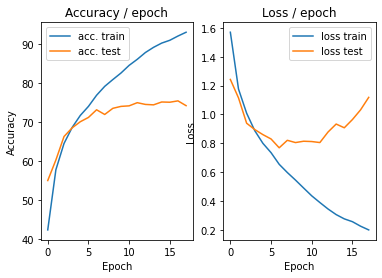

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.612s (0.612s)	Loss 0.1928 (0.1928)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


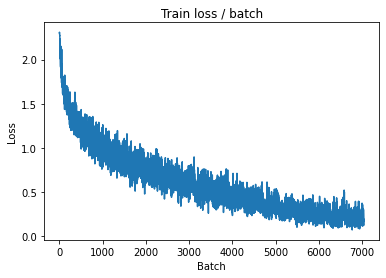

[TRAIN Batch 200/391]	Time 0.177s (0.186s)	Loss 0.2130 (0.1814)	Prec@1  92.2 ( 93.6)	Prec@5 100.0 (100.0)


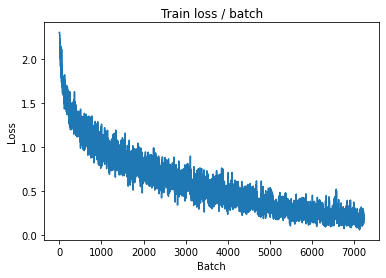


===============> Total time 71s	Avg loss 0.1908	Avg Prec@1 93.22 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.232s (0.232s)	Loss 1.3691 (1.3691)	Prec@1  77.3 ( 77.3)	Prec@5  96.1 ( 96.1)

===============> Total time 5s	Avg loss 1.1487	Avg Prec@1 73.77 %	Avg Prec@5 97.77 %



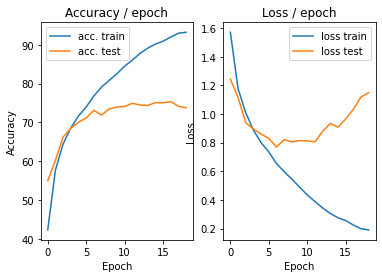

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.432s (0.432s)	Loss 0.1295 (0.1295)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


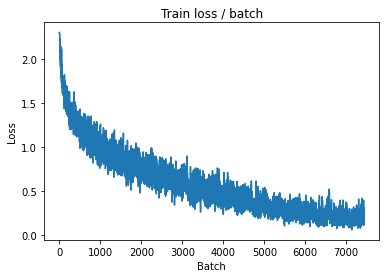

[TRAIN Batch 200/391]	Time 0.208s (0.190s)	Loss 0.1788 (0.1525)	Prec@1  93.8 ( 94.5)	Prec@5 100.0 (100.0)


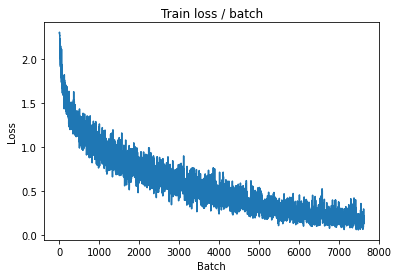


===============> Total time 73s	Avg loss 0.1723	Avg Prec@1 93.91 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.215s (0.215s)	Loss 1.3582 (1.3582)	Prec@1  77.3 ( 77.3)	Prec@5  95.3 ( 95.3)

===============> Total time 5s	Avg loss 1.1479	Avg Prec@1 74.24 %	Avg Prec@5 97.74 %



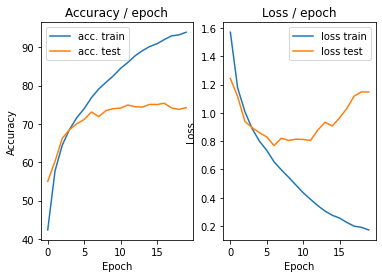

In [113]:
main(128, 0.1, epochs = 20, cuda=False)